This is a noisy trajectory, without weigths

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;</style>"))
import os 
os.chdir("..")
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from numerics.integration.matrices import *
from numerics.utilities.misc import *
import tensorflow as tf
from numerics.machine_learning.models import * 
import matplotlib.pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


2022-05-16 22:14:37.698262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 22:14:37.698282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-16 22:14:40.115862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-16 22:14:40.115887: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-16 22:14:40.115903: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [2]:
params, exp_path = def_params()
xi, kappa, omega, eta = params

T = 100.
dt = 1e-3

total_time,dt = T*kappa, kappa*dt


states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)

times = get_time(total_time,dt).astype(np.float32)
dd = tf.unstack(dys_si.astype(np.float32),axis=1)

tfsignals = tf.stack([times[:-1],dd[0], dd[1]])
tfsignals = tf.transpose(tfsignals)[tf.newaxis]

2022-05-16 22:14:43.676094: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


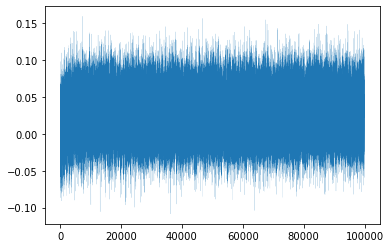

In [3]:
plt.plot(tfsignals[0][:,1], linewidth=0.1)

In [4]:
params, exp_path = def_params()

initial_parameters = np.array([-10., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)


In [5]:
params, exp_path = def_params()

initial_parameters = np.array([1., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 1#len(tfsignals[0])
batch_shape = [BS, None, 3]
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, initial_states = np.zeros((1,5)).astype(np.float32),
              cov_in=covss, batch_size=tuple([None,None,3]))#tuple(batch_shape))
model.recurrent_layer.build(tf.TensorShape(batch_shape))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [6]:
spp = tf.split(tfsignals, 5000, axis=1)

In [7]:
n_epochs = 10

In [8]:
cc = []
for epoch in range(n_epochs):
    model.reset_states()  
    for k in spp:
        bb = model.train_step((k,k))
        cc+=[bb]
    loss =  np.squeeze(bb["LOSS"].numpy())
    print("\r EPOCH {}/{}   loss:{}    params{}    grads{}".format(epoch, n_epochs,loss, np.squeeze(bb["PARAMS"].numpy()), np.squeeze(bb["GRADS"].numpy())),end="")
    if loss<1e-6:
        break

 EPOCH 9/10   loss:0.015579653903841972    params[10.031782    0.62831855]    grads[2.2563504e-06 0.0000000e+00]

In [25]:
def plot_history(cc, preds=None):
    plt.figure(figsize=(20,5))
    if preds is None:

        ax1 = plt.subplot(131)
        ax2 = plt.subplot(132)
        ax3 = plt.subplot(133)       
    else:
        ax1 = plt.subplot(141)
        ax2 = plt.subplot(142)
        ax3 = plt.subplot(143)       
        ax4 = plt.subplot(144)
    
    LL = 0.5
    history_loss = np.squeeze([cc[k]["LOSS"] for k in range(len(cc))])
    ax1.set_title("LOSS")
    ax1.plot(history_loss, linewidth=LL)
    ax1.set_yscale("log")
    ax1.set_xlabel("GRADIENT STEP")
    
    params=np.squeeze([cc[k]["PARAMS"] for k in range(len(cc))])
    ax2.set_title("PARAMS")
    ax2.plot(params[:,0],label="RNN")
    ax2.plot(np.ones(len(params))*true_parameters[0], '--',label="true")
    ax2.set_xlabel("GRADIENT STEP")
    ax2.legend()
    
    grads = np.squeeze([cc[k]["LOSS"] for k in range(len(cc))])
    ax3.set_title("GRADS")
    ax3.plot(grads, linewidth=LL)
    ax3.set_yscale("log")
    
    if preds is not None:
        ax4.set_title("PREDICTIONS")
        ax4.plot(np.squeeze(preds)[:,0], '--',color="red", alpha=0.5,label="RNN")
        ax4.plot(dd[0], color="blue", label="true", alpha=0.5)
        ax4.legend()
        ax4.set_xlabel("TIME (physical)")

In [10]:
model.reset_states()
preds = model.predict(tfsignals)

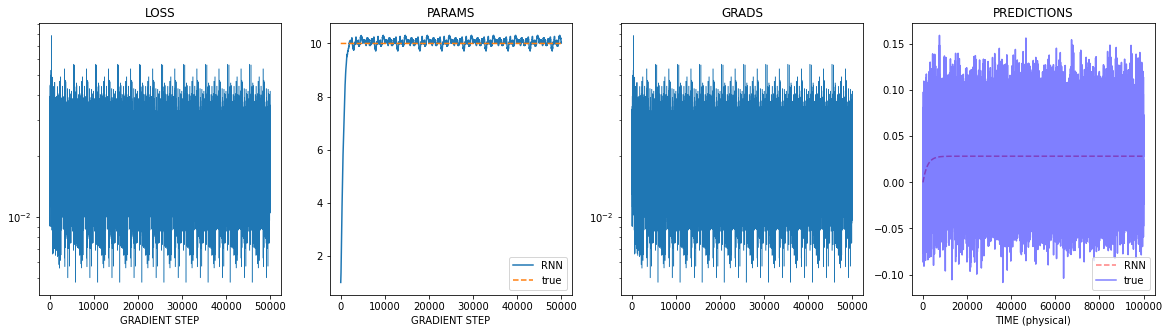

In [26]:
plot_history(cc, preds)